In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator, PercentFormatter
from tqdm import tqdm
from scipy.stats import norm
from collections import OrderedDict
import sys, os
from prisk.asset import PowerPlant, WareHouse, Manufacturing
from prisk.flood import FloodExposure, FloodEntitySim, FloodExceedanceCurve
from prisk.firm import Holding
from prisk.portfolio import Portfolio
from prisk.kernel import Kernel
from prisk.insurance import Insurance
# === AUTO-RELOAD SETUP ===
# This will automatically reload modules when they change
%load_ext autoreload
%autoreload 2

# This tells Jupyter to automatically reload any imported modules
# when their source code changes
print("Auto-reload enabled - modules will update automatically")

Auto-reload enabled - modules will update automatically


### Step 1: Load all data and set global analysis parameters

In [2]:
# Load CSVs
thailand_assets = pd.read_csv(r"C:\Users\Mark.DESKTOP-UFHIN6T\OneDrive - Nexus365\CFRF\2025\Deals_WG\PRISK\synthetic\realistic_synthetic_assets_thailand_flooded_point.csv")
financial_data = pd.read_csv(r"C:\Users\Mark.DESKTOP-UFHIN6T\OneDrive - Nexus365\CFRF\2025\Deals_WG\PRISK\synthetic\synthetic_owners_thailand.csv")
# Make RP columns int not str1
thailand_assets.columns = thailand_assets.columns.map(lambda c: int(c) if str(c).isdigit() else c)

In [3]:
leverage_ratios = {firm: leverage for firm, leverage in zip(financial_data["owner_name"], financial_data["leverage_ratio"])}
return_period_columns = [2, 5, 10, 25, 50, 100, 200, 500, 1000]
power_damage_curves = pd.read_excel(r"C:\Users\Mark.DESKTOP-UFHIN6T\OneDrive - Nexus365\CFRF\2025\Deals_WG\PRISK\power_damage_curves.xlsx")
manufacturing_damage_curves = pd.read_excel(r"C:\Users\Mark.DESKTOP-UFHIN6T\OneDrive - Nexus365\CFRF\2025\Deals_WG\PRISK\manufacturing_damage_curves.xlsx")
warehouse_damage_curves = pd.read_excel(r"C:\Users\Mark.DESKTOP-UFHIN6T\OneDrive - Nexus365\CFRF\2025\Deals_WG\PRISK\warehouse_damage_curves.xlsx")

In [4]:
# Global analysis parameters
time_horizon = 25 # for each simulation what is the time horizon we will look
discount_rate = 0.05 # 5% discount rate
manufacturing_unit_price = 2500 # pounds p.a. production (per m^2)
manufacturing_profit_margin = 0.07 # 7% profit margin for warehouse facilities
warehouse_unit_price = 500 # pounds p.a. rental income (per m^2)
warehouse_profit_margin = 0.1 # 10% profit margin for warehouse facilities
power_unit_price = 60 # pounds per MWh
power_profit_margin = 0.2 # 20% profit margin for electricity generation

### Step 2: Create assets and extract ownership

In [5]:
# Function to convert damage curves to continuous damage
def convert_to_continuous_damage(damage_curves):
    continuous_curves = pd.DataFrame({"index": range(0, int(max((damage_curves["depth"] + 0.01)*100)))})
    continuous_curves["index"] = continuous_curves["index"]/100
    continuous_curves.set_index("index", inplace=True)
    continuous_curves = continuous_curves.merge(damage_curves, how="left", left_index=True, right_on="depth")
    continuous_curves.interpolate(method="linear", inplace=True)
    continuous_curves.set_index("depth", inplace=True)
    return continuous_curves

In [6]:
# Create power assets
# User parameters
power_assets = thailand_assets[thailand_assets['asset_class']=='power'].copy() # filter by power assets
# For row in our power asset dataframe we are going to create a PowerPlant asset class
power_assets.loc[:, "asset"] = power_assets.apply(lambda x:
                                                 PowerPlant(
                                                     name=x["asset_name"], # assign asset name from dataframe
                                                     flood_damage_curve=convert_to_continuous_damage(power_damage_curves), # add specific power curves
                                                     flood_exposure=[FloodExposure(return_period, x[return_period]) 
                                                                    for return_period in return_period_columns if x[return_period] > 0], # populate flood exposure class with return period and depth info
                                                     flood_protection = x["flood_protection"], # flood protection is taken from FLOPROS column 
                                                     production_path=np.repeat(x["size"]*24*365, time_horizon), # calculate annual production of asset
                                                     replacement_cost=x['asset_value_usd'], # value of asset taken from spreadsheet
                                                     unit_price=power_unit_price,
                                                     discount_rate=discount_rate,
                                                     margin=power_profit_margin,
                                                 ), axis=1)

In [7]:
# Create warehouse assets
warehouse_assets = thailand_assets[thailand_assets['asset_class']=='warehouse'].copy() # filter by warehouse assets
# For row in our warhouse asset dataframe we are going to create a WareHouse asset class
warehouse_assets.loc[:, "asset"] = warehouse_assets.apply(lambda x:
                                                 WareHouse(
                                                     name=x["asset_name"], # assign asset name from dataframe
                                                     flood_damage_curve=convert_to_continuous_damage(warehouse_damage_curves), # add specific warehouse curves
                                                     flood_exposure=[FloodExposure(return_period, x[return_period]) 
                                                                    for return_period in return_period_columns if x[return_period] > 0], # populate flood exposure class with return period and depth info
                                                     flood_protection = x["flood_protection"], # flood protection is taken from FLOPROS column 
                                                     production_path=np.repeat(x["size"], time_horizon), # calculate annual production of asset
                                                     replacement_cost=x['asset_value_usd'], # value of asset taken from spreadsheet
                                                     unit_price=warehouse_unit_price,
                                                     discount_rate=discount_rate,
                                                     margin=warehouse_profit_margin,
                                                 ), axis=1)

In [8]:
# Create manufacturing assets
manufacturing_assets = thailand_assets[thailand_assets['asset_class']=='manufacturing'].copy() # filter by manufacturing assets
# For row in our manufacturing asset dataframe we are going to create a Manufacturing asset class
manufacturing_assets.loc[:, "asset"] = manufacturing_assets.apply(lambda x:
                                                 Manufacturing(
                                                     name=x["asset_name"], # assign asset name from dataframe
                                                     flood_damage_curve=convert_to_continuous_damage(manufacturing_damage_curves), # add specific maufacturing curves
                                                     flood_exposure=[FloodExposure(return_period, x[return_period]) 
                                                                    for return_period in return_period_columns if x[return_period] > 0], # populate flood exposure class with return period and depth info
                                                     flood_protection = x["flood_protection"], # flood protection is taken from FLOPROS column 
                                                     production_path=np.repeat(x["size"], time_horizon), # calculate annual production of asset
                                                     replacement_cost=x['asset_value_usd'], # value of asset taken from spreadsheet
                                                     unit_price=manufacturing_unit_price,
                                                     discount_rate=discount_rate,
                                                     margin=manufacturing_profit_margin,
                                                 ), axis=1)

In [9]:
# Create a combined asset dataframe
combined_assets = pd.concat(
    [power_assets, warehouse_assets, manufacturing_assets],
    axis=0,
    ignore_index=True
)

In [10]:
# Extract the firms that own these assets
list_of_owners = []
for owners in combined_assets["owner_name"].unique(): # pull uniqute owner names
    if pd.isna(owners): 
        continue
    list_of_owners.append(owners) # populate list
list_of_owners = list(OrderedDict.fromkeys(list_of_owners)) # remove any duplicates
owner_map = {owner: Holding(owner, leverage_ratio=leverage_ratios.get(owner)) for owner in list_of_owners} # Create a dic of owners and creates holding class for each
# Create holding firms (collection of assets with a certain percentage of ownership)
holdings = []
for i, owner in enumerate(combined_assets["owner_name"]):
    if pd.isna(owner):
        continue
    share = 1 # here assuming each asset only has one owner (can have multi-owner structure too)
    holding = owner_map[owner]
    holding.add_asset(combined_assets.loc[i, "asset"], share)
    holdings.append(holding)
firms = list(OrderedDict.fromkeys(holdings)) # remove any duplicates

### Step 3: Run simulation

In [11]:
# Functions
def merton_probability_of_default(V, sigma_V, D, r=0, T=1, eps=1e-12):
    """
    Calculate the probability of default using the Merton model.

    Parameters:
    V (float): Current value of the company's assets.
    sigma_V (float): Volatility of the company's assets.
    D (float): Face value of the company's debt.
    r (float): Risk-free interest rate.
    T (float): Time to maturity of the debt.

    Returns:
    float: Probability of default.
    """
    # Avoid runtime error
    V = max(V, eps)
    D = max(D, eps)
    sigma_V = max(sigma_V, eps)
    T = max(T, eps)
    
    # Calculate d2
    d2 = (np.log(V / D) + (r - 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
    # Calculate the probability of default
    PD = norm.cdf(-d2)
    return PD

def apply_firm_adaptation(portfolio, firm_name, protection_level):
    """
    Apply flood protection to all assets owned by a specific firm
    
    Parameters
    ----------
    portfolio : Portfolio
        Your portfolio object
    firm_name : str
        Name of the firm (as it appears in the firm column)
    protection_level : float
        Return period for flood protection (e.g., 100 for 100-year flood)
    """
    assets_df = portfolio.assets
    
    # Find all assets owned by the firm
    firm_assets = assets_df[assets_df['firm'].astype(str) == firm_name]
    
    updated_count = 0
    for _, row in firm_assets.iterrows():
        asset = row['asset']
        asset.flood_protection = protection_level
        asset.update_expected_damage()
        updated_count += 1
    
    print(f"Applied {protection_level}-year flood protection to {updated_count} assets owned by {firm_name}")
    return updated_count

def apply_asset_adaptation(portfolio, asset_names, protection_level):
    """
    Apply flood protection to specific assets by name
    
    Parameters
    ----------
    portfolio : Portfolio
        Your portfolio object
    asset_names : str or list
        Asset name(s) to protect
    protection_level : float
        Return period for flood protection (e.g., 100 for 100-year flood)
    """
    if isinstance(asset_names, str):
        asset_names = [asset_names]
    
    assets_df = portfolio.assets
    updated_count = 0
    
    for asset_name in asset_names:
        # Find assets matching the name
        matching_assets = assets_df[assets_df['asset'].astype(str) == asset_name]
        
        for _, row in matching_assets.iterrows():
            asset = row['asset']
            asset.flood_protection = protection_level
            asset.update_expected_damage()
            updated_count += 1
    
    print(f"Applied {protection_level}-year flood protection to {updated_count} assets: {asset_names}")
    return updated_count

def apply_portfolio_adaptation(portfolio, protection_level):
    """
    Apply flood protection to all assets in the portfolio
    
    Parameters
    ----------
    portfolio : Portfolio
        Your portfolio object
    protection_level : float
        Return period for flood protection (e.g., 100 for 100-year flood)
    """
    assets_df = portfolio.assets
    updated_count = 0
    
    for _, row in assets_df.iterrows():
        asset = row['asset']
        asset.flood_protection = protection_level
        asset.update_expected_damage()
        updated_count += 1
    
    print(f"Applied {protection_level}-year flood protection to all {updated_count} assets in portfolio")
    return updated_count
    
def plot_portfolio_values(pv_list, label):
    fig, ax = plt.subplots(figsize=(6, 3))
    # (PRISK)
    ax.hist(pv_list, bins=20, density=False, alpha=0.5, color='lightblue', edgecolor='black', label=label)
    ax.set_title("Distribution of Portfolio Values")
    ax.set_xlabel("Portfolio Value")
    ax.legend()
    # ax.set_xlim(0.996, 1)
    ax.set_ylabel("Count")

def collect_asset_data(assets):
    """Collect current state data from all assets"""
    asset_data = []
    for asset in assets:
        data = {
            'name': asset.name,
            'climate_cost_path': asset.climate_cost_path,
            'total_replacement_costs': asset.total_replacement_costs,
            'total_business_disruption': asset.total_business_disruption,
            'fair_premiums': asset.total_fair_insurance_premiums,
            'npv_loss': asset.base_value - asset.npv,
            'damage_ratio': sum(asset.climate_cost_path) / asset.base_value if asset.base_value > 0 else 0
        }
        asset_data.append(data)
    return asset_data

In [12]:
# Set simulation parameters
insured = False
ins_cap = 2e9
n_sims = 1000
sigma = 0.2 

In [13]:
# Create a "portfolio" for simulation
portfolio = Portfolio("Simulation Portfolio")
nav=1
for firm in firms:
    portfolio.add_position(firm, nav/(len(firms)*firm.npv))

##### Baseline

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [21:21<00:00,  1.28s/it]


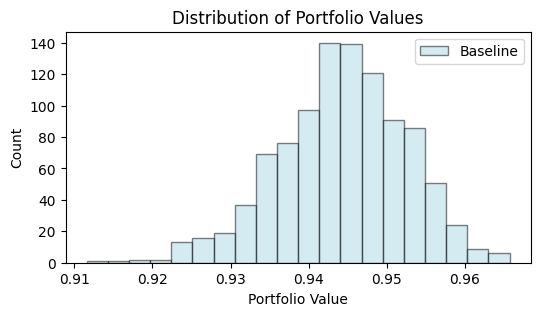

In [14]:
# Run baseline simulation
baseline_portfolio_values = []
firm_names = [firm.name for firm in firms] # Get firm names for tracking
baseline_firm_pd_data = {name: [] for name in firm_names}  # Store PDs by firm name
baseline_firm_damage_ratio = {name: [] for name in firm_names} # Store Damage ratio by firm name
baseline_asset_simulation_data = []
np.random.seed(0)
for i in tqdm(range(n_sims)):
    assets = portfolio.assets.asset.to_list().copy()
    insurer = Insurance("Insurance company", capital=ins_cap, subscribers=[])
    kernel = Kernel(assets=assets, insurers=[insurer])
    for asset in assets: 
        if insured:
            asset.add_insurer(insurer)
        # Flood entity sim simulates floods at the asset-level without considering other asset events
        FloodEntitySim(asset, model="exceedance_poisson").simulate(time_horizon=time_horizon, kernel=kernel)
    kernel.run(time_horizon=time_horizon, verbose=0)
    baseline_portfolio_values.append(portfolio.underlying_value)
    # Calculate Merton PDs for each firm and store by name
    for firm in firms:
        # Calculate change in PD
        base_pd = merton_probability_of_default(V=firm.base_value, sigma_V=sigma, D=firm.original_liabilities)
        post_pd = merton_probability_of_default(V=firm.npv, sigma_V=sigma, D=firm.original_liabilities)
        delta_pd = post_pd - base_pd
        # Store in firm-specific list
        baseline_firm_pd_data[firm.name].append(delta_pd)
        # Calculate damage ratio
        total_damages = firm.total_replacement_costs + firm.total_business_disruption
        damage_ratio = total_damages / firm.base_value if firm.base_value > 0 else 0
        baseline_firm_damage_ratio[firm.name].append(damage_ratio)
    # Collect asset-level data before reset
    asset_data = collect_asset_data(assets)
    baseline_asset_simulation_data.append(asset_data)
    for asset in assets:
        asset.reset() # Reset assets to their original state
plot_portfolio_values(baseline_portfolio_values, 'Baseline')

##### Adaptation

In [59]:
# Can run different adaptation scenarios (comment out the one we are interested in)
adaptation_portfolio = copy.deepcopy(portfolio) #
# Scenario 1: All assets are protected up to 50-year flood
apply_portfolio_adaptation(adaptation_portfolio, 100)
# Update exceedance curves for all assets in portfolio
adaptation_portfolio.update_exceedance_curves()
# # Scenario 2: Certain companies enact policy to reinforce assets to 100-year protection
# company_names = ['Thai Holdings 001', 'Thai Holdings 002', 'Thai Holdings 003', 'Thai Holdings 004', 'Thai Holdings 005',
#                 'Thai Holdings 006', 'Thai Holdings 007', 'Thai Holdings 008', 'Thai Holdings 009', 'Thai Holdings 010',
#                 'Thai Holdings 038', 'Thai Holdings 018', 'Thai Holdings 027', 'Thai Holdings 020', 'Thai Holdings 049']
# for company in company_names:
#     apply_firm_adaptation(adaptation_portfolio, company, 100)
# # Update exceedance curves for all assets in portfolio
# adaptation_portfolio.update_exceedance_curves()

Applied 100-year flood protection to all 1750 assets in portfolio


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [18:38<00:00,  1.12s/it]


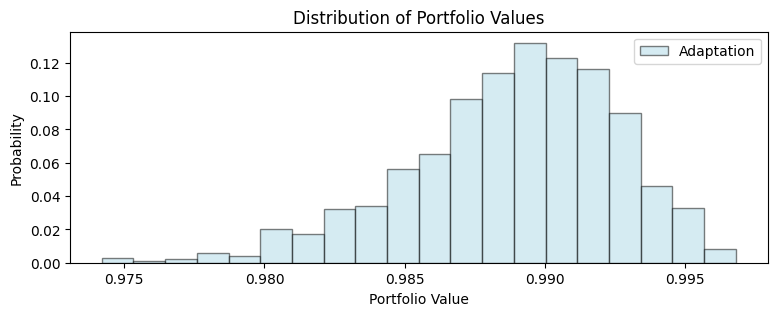

In [60]:
# Run adaptation simulation
adaptation_portfolio_values = []
firm_names = [firm.name for firm in firms] # Get firm names for tracking
adaptation_firm_pd_data = {name: [] for name in firm_names}  # Store PDs by firm name
adaptation_firm_damage_ratio = {name: [] for name in firm_names} # Store Damage ratio by firm name
adapted_asset_simulation_data = [] # list for storing
np.random.seed(0)
for i in tqdm(range(n_sims)):
    assets = adaptation_portfolio.assets.asset.to_list().copy()
    insurer = Insurance("Insurance company", capital=ins_cap, subscribers=[]) 
    kernel = Kernel(assets=assets, insurers=[insurer])
    for asset in assets:
        if insured:
            asset.add_insurer(insurer)
        # Flood entity sim simulates floods at the asset-level without considering other asset events
        FloodEntitySim(asset, model="exceedance_poisson").simulate(time_horizon=time_horizon, kernel=kernel)
    kernel.run(time_horizon=time_horizon, verbose=0)
    adaptation_portfolio_values.append(adaptation_portfolio.underlying_value)
    # Pull adaptation firms
    adaptation_firms = adaptation_portfolio.positions.firm
    # Calculate Merton PDs for each firm and store by name
    for firm in adaptation_firms:
        # Calculate change in PD
        base_pd = merton_probability_of_default(V=firm.base_value, sigma_V=sigma, D=firm.original_liabilities)
        post_pd = merton_probability_of_default(V=firm.npv, sigma_V=sigma, D=firm.original_liabilities)
        delta_pd = post_pd - base_pd
        # Store in firm-specific list
        adaptation_firm_pd_data[firm.name].append(delta_pd)
        # Calculate damage ratio
        total_damages = firm.total_replacement_costs + firm.total_business_disruption
        damage_ratio = total_damages / firm.base_value if firm.base_value > 0 else 0
        adaptation_firm_damage_ratio[firm.name].append(damage_ratio)
    # Collect asset-level data before reset
    asset_data = collect_asset_data(assets)
    adapted_asset_simulation_data.append(asset_data)
    for asset in assets:
        asset.reset() # Reset assets to their original state
plot_portfolio_values(adaptation_portfolio_values, 'Adaptation')

### Step 3: Various Plots

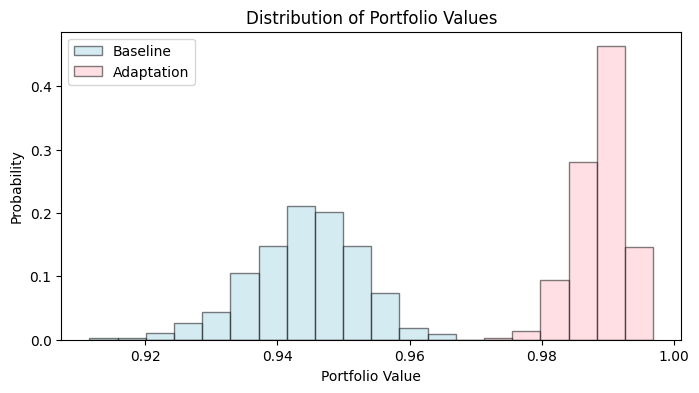

In [61]:
# Plot them together as probability densitiies
fig, ax = plt.subplots(figsize=(8, 4))

# Common bin edges
all_values = np.concatenate([baseline_portfolio_values, adaptation_portfolio_values])
bins = np.linspace(all_values.min(), all_values.max(), 21)

# Weights so that the bars sum to 1
w_baseline = np.ones_like(baseline_portfolio_values) / len(baseline_portfolio_values)
w_adapt = np.ones_like(adaptation_portfolio_values) / len(adaptation_portfolio_values)

# Probability per bin histograms
ax.hist(baseline_portfolio_values, bins=bins, weights=w_baseline,
        alpha=0.5, color='lightblue', edgecolor='black', label='Baseline')
ax.hist(adaptation_portfolio_values, bins=bins, weights=w_adapt,
        alpha=0.5, color='pink', edgecolor='black', label='Adaptation')

ax.set_title("Distribution of Portfolio Values")
ax.set_xlabel("Portfolio Value")
ax.set_ylabel("Probability")
ax.legend()
plt.show()

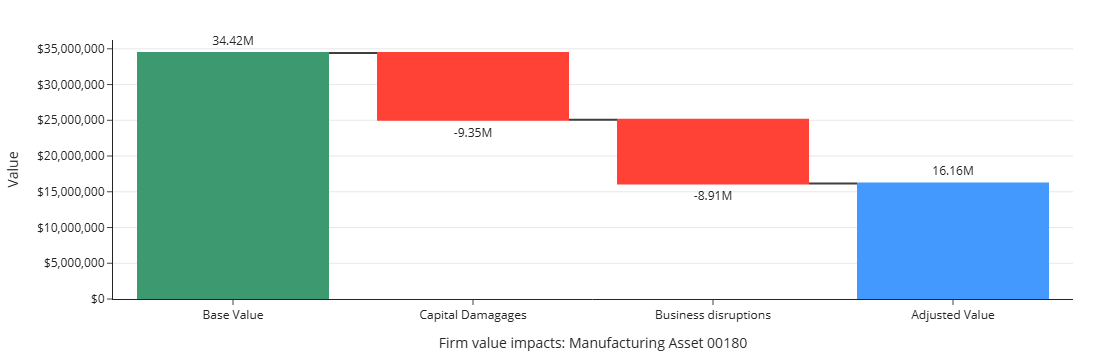

In [62]:
# Plot asset-level waterfall chart
temp_portfolio = copy.deepcopy(portfolio) 
assets = temp_portfolio.assets.asset.to_list().copy()
insurer = Insurance("Insurance company", capital=ins_cap, subscribers=[]) 
kernel = Kernel(assets=assets, insurers=[insurer])
np.random.seed(0)
for asset in assets:
    # Flood entity sim simulates floods at the asset-level without considering other asset events
    FloodEntitySim(asset, model="exceedance_poisson").simulate(time_horizon=25, kernel=kernel)
kernel.run(time_horizon=time_horizon, verbose=0)
asset_id = 45
# temp_portfolio.assets.asset[asset_id].plot_simple_risk()
asset_list = sorted(temp_portfolio.assets.asset, key=lambda x: x.total_replacement_costs, reverse=True)
asset_list[asset_id].plot_simple_risk()

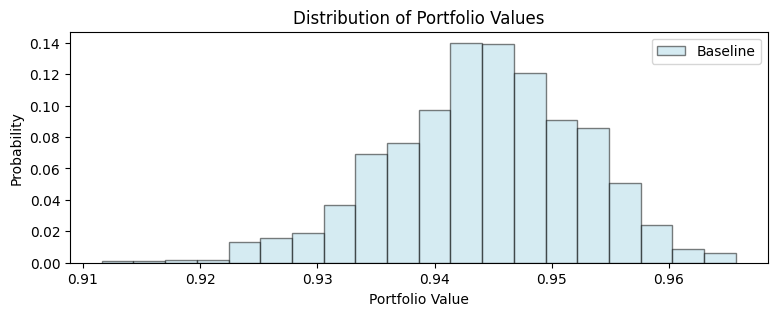

In [19]:
def plot_portfolio_values(pv_list, label):
    fig, ax = plt.subplots(figsize=(9, 3))
    counts, bins, _ = ax.hist(pv_list, bins=20, alpha=0.5, edgecolor='black', color='lightblue')
    ax.clear()

    # Normalize so bar heights = probabilities
    probs = counts / counts.sum()
    ax.bar(bins[:-1], probs, width=np.diff(bins), align="edge",
           alpha=0.5, edgecolor="black", color="lightblue", label=label)

    ax.set_title("Distribution of Portfolio Values")
    ax.set_xlabel("Portfolio Value")
    ax.set_ylabel("Probability")
    ax.legend()

plot_portfolio_values(baseline_portfolio_values, 'Baseline')

##### PD plots

In [20]:
# Analyze PD
baseline_firm_pd_df = pd.DataFrame(baseline_firm_pd_data)
baseline_firm_pd_df.index.name = 'simulation'
adaptation_firm_pd_df = pd.DataFrame(adaptation_firm_pd_data)
adaptation_firm_pd_df.index.name = 'simulation'

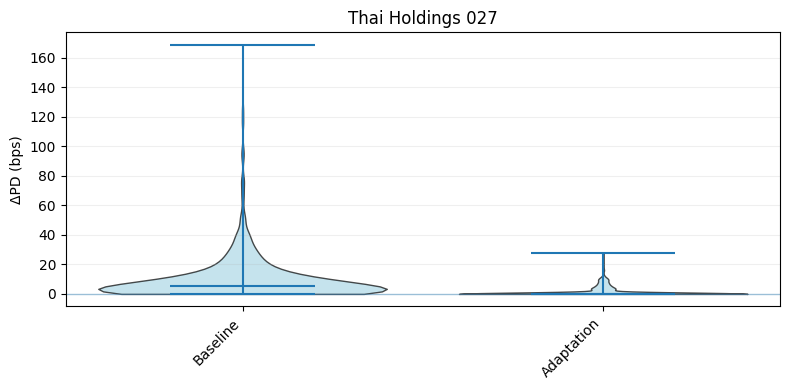

In [21]:
# Plot baseline and adapted firm PDs
firm_a = 'Thai Holdings 027'
firm_a_baseline = baseline_firm_pd_df[firm_a]
firm_a_adapted = adaptation_firm_pd_df[firm_a]
combined = pd.concat([firm_a_baseline, firm_a_adapted], axis=1)
fig, ax = plt.subplots(figsize=(8, 4))
parts = ax.violinplot(
    combined,
    positions=range(1, len(combined.columns) + 1),
    widths=0.8,
    showmeans=False,
    showmedians=True,
    showextrema=True
)

# Style violins
for pc in parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# X labels
ax.set_xticks(range(1, len(combined.columns) + 1))
custom_labels = ['Baseline', 'Adaptation']
ax.set_xticklabels(custom_labels, rotation=45, ha="right")

# format y ticks as bps without changing data
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y*1e4:.0f}"))
ax.set_ylabel("ΔPD (bps)")
ax.axhline(0, lw=1, alpha=0.4)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_title(f"{firm_a}")
ax.set_ylabel("ΔPD (bps)")
ax.grid(axis='y', alpha=0.2)

plt.tight_layout()
plt.show()

In [22]:
def plot_pd_distributions(df, companies_to_plot):
    """
    Plot violin distributions of ΔPD for specific companies.
    
    Parameters
    ----------
    df : DataFrame
        Columns = companies, rows = ΔPD values
    companies_to_plot : list of str
        List of company names (must match df.columns)
    """
    # Select only the specified companies
    cols = [c for c in companies_to_plot if c in df.columns]
    data = [df[c].dropna().values for c in cols]

    fig, ax = plt.subplots(figsize=(9, 4))

    parts = ax.violinplot(
        data,
        positions=range(1, len(cols) + 1),
        widths=0.8,
        showmeans=False,
        showmedians=True,
        showextrema=True
    )

    # Style violins
    for pc in parts['bodies']:
        pc.set_facecolor('lightblue')
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
    
    # X labels
    ax.set_xticks(range(1, len(cols) + 1))
    custom_labels = ['Firm A', 'Firm B', 'Firm C', 'Firm D']
    ax.set_xticklabels(custom_labels, rotation=45, ha="right")

    ax.set_title("Distribution of Probability of Default (ΔPD) across Selected Firms")
    ax.set_ylabel("ΔPD")
    ax.grid(axis='y', alpha=0.2)

    plt.tight_layout()
    plt.show()

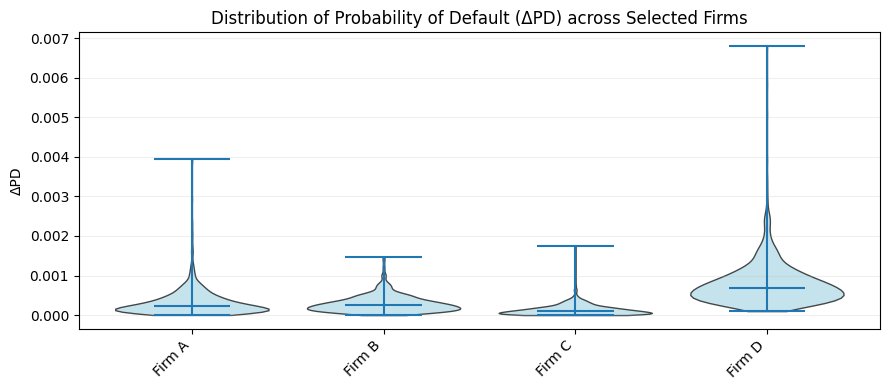

In [23]:
# Plot multi compant PDs
company_names = ['Thai Holdings 037', 'Thai Holdings 045', 'Thai Holdings 013', 'Thai Holdings 042']
plot_pd_distributions(baseline_firm_pd_df, company_names)

##### Asset-specific E-P curves

In [24]:
# Plot loss probability curves
def ep_curve(losses):
    """Return (loss_sorted, exceedance_prob) using Weibull plotting positions."""
    x = np.sort(np.asarray(losses))            # ascending loss
    n = x.size
    # Exceedance probability P(Loss ≥ x_i)
    ep = (n - np.arange(1, n+1) + 1) / (n + 1.0)
    return x, ep

# curves
x_b, ep_b = ep_curve(baseline_asset_aal)
x_a, ep_a = ep_curve(adapted_asset_aal)

# AALs
aal_b = float(np.mean(baseline_asset_aal))
aal_a = float(np.mean(adapted_asset_aal))

# plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x_b, ep_b, color='blue', label="Baseline")
ax.plot(x_a, ep_a, color='orange', label="Adaptation")

# y as Annual Exceedance Probability (AEP)
ax.set_yscale('log')
ax.set_xscale('log')
# lower y-limit ~ 1/N, upper at 1
ymin = 1.0 / (len(baseline_asset_aal) + 1.0)
ax.set_ylim(ymin, 1)
ax.yaxis.set_major_formatter(PercentFormatter(2))  # show as %

# AAL markers (vertical lines)
ax.axvline(aal_b, linestyle='--', color='blue', linewidth=1, label=f"AAL baseline ($ {aal_b:,.0f})")
ax.axvline(aal_a, linestyle='--', color='orange',  linewidth=1, label=f"AAL adaptation ($ {aal_a:,.0f})")

ax.set_xlabel("Annual Loss ($)")
ax.set_ylabel("Exceedance probability (AEP)")
ax.set_title("Warehouse Asset 01054 Loss–Exceedance Curve (Baseline vs Adaptation)")
ax.grid(True, which='both', axis='both', alpha=0.2)
ax.legend()
plt.tight_layout()
plt.show()

NameError: name 'baseline_asset_aal' is not defined

### SCRATCH ZONE

In [63]:
def analyze_simulation_results(all_simulation_data):
    """Analyze results across multiple simulations"""
    # Convert list of dictionaries to organized structure
    asset_results = {}
    
    for sim_data in all_simulation_data:
        for asset_info in sim_data:
            asset_name = asset_info['name']
            if asset_name not in asset_results:
                asset_results[asset_name] = {
                    'climate_cost_path': [],
                    'total_replacement_costs': [],
                    'total_business_disruption': [],
                    'npv_losses': [],
                    'damage_ratios': []
                }
            
            asset_results[asset_name]['climate_cost_path'].append(asset_info['climate_cost_path'])
            asset_results[asset_name]['total_replacement_costs'].append(asset_info['total_replacement_costs'])
            asset_results[asset_name]['total_business_disruption'].append(asset_info['total_business_disruption'])
            asset_results[asset_name]['npv_losses'].append(asset_info['npv_loss'])
            asset_results[asset_name]['damage_ratios'].append(asset_info['damage_ratio'])
    
    # Calculate summary statistics
    summary = []
    for asset_name, data in asset_results.items():
        summary.append({
            'asset_name': asset_name,
            'mean_replacement_costs': np.mean(data['total_replacement_costs']),
            'std_replacement_costs': np.std(data['total_replacement_costs']),
            'p95_replacement_costs': np.percentile(data['total_replacement_costs'], 95),
            'p99_replacement_costs': np.percentile(data['total_replacement_costs'], 99),
            'max_replacement_costs': np.max(data['total_replacement_costs']),
            'loss_frequency': np.sum(np.array(data['total_replacement_costs']) > 0) / len(data['total_replacement_costs']),
            'mean_damage_ratio': np.mean(data['damage_ratios']),
            'p95_damage_ratio': np.percentile(data['damage_ratios'], 95)
        })
    
    return pd.DataFrame(summary).sort_values('mean_replacement_costs', ascending=False), asset_results

In [64]:
baseline_summary_df, baseline_detailed_results = analyze_simulation_results(baseline_asset_simulation_data)
adapted_summary_df, adapted_detailed_results = analyze_simulation_results(adapted_asset_simulation_data)

In [65]:
baseline_summary_df.head()

,asset_name,mean_replacement_costs,std_replacement_costs,p95_replacement_costs,p99_replacement_costs,max_replacement_costs,loss_frequency,mean_damage_ratio,p95_damage_ratio
322,Power Asset 00014,4.546154e+08,4.179144e+08,1.271658e+09,1.759871e+09,2.668646e+09,0.741,0.518359,1.230126
521,Power Asset 00029,3.781701e+08,3.505388e+08,1.087751e+09,1.402469e+09,2.075015e+09,0.757,0.495308,1.397341
1087,Power Asset 00065,3.474948e+08,3.249537e+08,9.544640e+08,1.357453e+09,1.817185e+09,0.742,0.492157,1.355671
1337,Power Asset 00128,3.274950e+08,2.923450e+08,9.365484e+08,1.178252e+09,1.405982e+09,0.751,0.475713,1.322454
793,Power Asset 00040,2.108883e+08,1.922343e+08,5.747749e+08,7.630579e+08,1.176081e+09,0.754,0.555571,1.545398


In [66]:
adapted_summary_df.head()

,asset_name,mean_replacement_costs,std_replacement_costs,p95_replacement_costs,p99_replacement_costs,max_replacement_costs,loss_frequency,mean_damage_ratio,p95_damage_ratio
322,Power Asset 00014,9.212444e+07,1.955838e+08,5.125087e+08,8.353871e+08,1.369284e+09,0.221,0.105400,0.428280
521,Power Asset 00029,6.993071e+07,1.586730e+08,4.371266e+08,6.815133e+08,9.985310e+08,0.200,0.088360,0.390948
1087,Power Asset 00065,6.587396e+07,1.468882e+08,4.168681e+08,6.233814e+08,9.570031e+08,0.202,0.087636,0.393145
433,Power Asset 00134,6.083470e+07,1.274082e+08,3.322464e+08,5.175480e+08,1.298395e+09,0.245,0.097024,0.375876
1337,Power Asset 00128,5.588009e+07,1.216937e+08,3.603548e+08,5.031254e+08,6.875600e+08,0.211,0.081250,0.345000


In [70]:
# asset = 'Warehouse Asset 01077'
asset = 'Warehouse Asset 01085'
# asset = 'Warehouse Asset 01491'
# asset = 'Warehouse Asset 01600'
# asset = 'Warehouse Asset 01668'
# asset = 'Warehouse Asset 01679'
# asset = 'Warehouse Asset 01683'
# asset = 'Manufacturing Asset 00709'
baseline_losses = [i for sublist in baseline_detailed_results[asset]['climate_cost_path'] for i in sublist]
adapted_losses = [i for sublist in adapted_detailed_results[asset]['climate_cost_path'] for i in sublist]

In [71]:
print(baseline_losses[:10])
print(adapted_losses[:10])

[np.int64(0), np.int64(43423), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(68423), np.int64(0), np.int64(104403), np.int64(0)]
[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


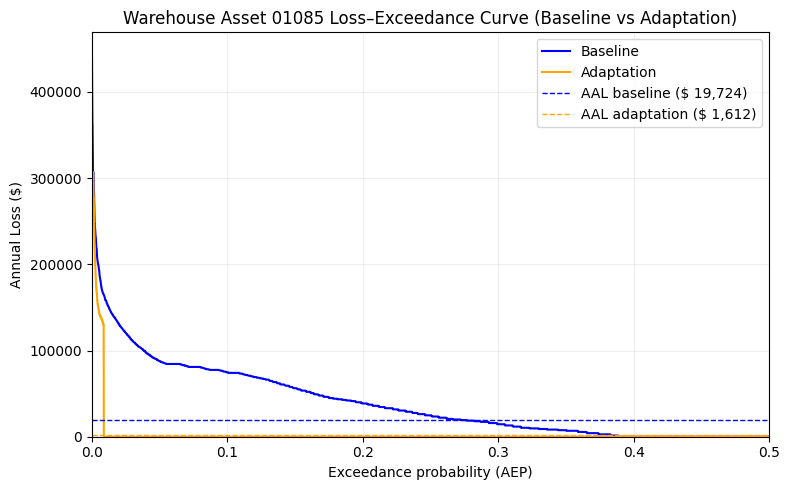

In [72]:
# Plot loss probability curves
def ep_curve(losses):
    """Return (loss_sorted, exceedance_prob) using Weibull plotting positions."""
    x = np.sort(np.asarray(losses))            # ascending loss
    n = x.size
    # Exceedance probability P(Loss ≥ x_i)
    ep = (n - np.arange(1, n+1) + 1) / (n + 1.0)
    return x, ep

# curves
x_b, ep_b = ep_curve(baseline_losses)
x_a, ep_a = ep_curve(adapted_losses)

# AALs
aal_b = float(np.mean(baseline_losses))
aal_a = float(np.mean(adapted_losses))

# plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ep_b, x_b, color='blue', label="Baseline")
ax.plot(ep_a, x_a, color='orange', label="Adaptation")

# y as Annual Exceedance Probability (AEP)
# ax.set_yscale('log')
# ax.set_xscale('log')
# lower y-limit ~ 1/N, upper at 1
# xmin = 1.0 / (len(baseline_losses) + 1.0)
ax.set_xlim(0, 0.5)
ax.set_ylim(0, )
# ax.xaxis.set_major_formatter(PercentFormatter(2))  # show as %

# AAL markers (vertical lines)
ax.axhline(aal_b, linestyle='--', color='blue', linewidth=1, label=f"AAL baseline ($ {aal_b:,.0f})")
ax.axhline(aal_a, linestyle='--', color='orange',  linewidth=1, label=f"AAL adaptation ($ {aal_a:,.0f})")

ax.set_ylabel("Annual Loss ($)")
ax.set_xlabel("Exceedance probability (AEP)")
ax.set_title(f"{asset} Loss–Exceedance Curve (Baseline vs Adaptation)")
ax.grid(True, which='both', axis='both', alpha=0.2)
ax.legend()
plt.tight_layout()
plt.show()

In [87]:
asset_id = 1
firm_id = 1
print('Company Name:', firms[firm_id].name)
print('Total Assets:', len(firms[firm_id].assets))
print('Revenue:', firms[firm_id].revenue)
print('NPV:', firms[firm_id].npv)
print('Total Replacement Cost:', firms[firm_id].baseline_replacement_costs)
print('Asset Name:', firms[firm_id].assets[asset_id].name)
print('Revenue:', firms[firm_id].assets[asset_id].revenue_path[0])
print('Terminal Value:', firms[firm_id].assets[asset_id].terminal_value)
print('NPV:', firms[firm_id].assets[asset_id].npv)
print('Replacement Cost:', firms[firm_id].assets[asset_id].replacement_cost)

Company Name: Thai Holdings 024
Total Assets: 38
Revenue: 553093014.0
NPV: 1273258468.5932705
Total Replacement Cost: 1140138480.54
Asset Name: Power Asset 00091
Revenue: 72312048.0
Terminal Value: 289248191.9999999
NPV: 290362133.59596837
Replacement Cost: 268873227.5


In [169]:
# Loop through and find the highest revenue generating assets
asset_name = []
asset_revenue = []
for i in range(len(firms[firm_id].assets)):
    asset_name.append(firms[firm_id].assets[i].name)
    asset_revenue.append(firms[firm_id].assets[i].revenue_path[0])
print('Total Revenue of all Assets Summed')
print(np.sum(asset_revenue))
combined = list(zip(asset_revenue, asset_name))
combined.sort(reverse=True, key=lambda x: x[0])
asset_revenue, asset_name = zip(*combined)
print(asset_name[:10])
print(asset_revenue[:10])

Total Revenue of all Assets Summed
553093014.0
('Power Asset 00116', 'Power Asset 00091', 'Manufacturing Asset 00625', 'Manufacturing Asset 00528', 'Power Asset 00002', 'Manufacturing Asset 00243', 'Manufacturing Asset 00495', 'Manufacturing Asset 00634', 'Manufacturing Asset 00682', 'Manufacturing Asset 00672')
(np.float64(72853416.0), np.float64(72312048.0), np.float64(46596600.0), np.float64(33643050.0), np.float64(27488879.999999996), np.float64(25233250.0), np.float64(22976350.000000004), np.float64(19688825.0), np.float64(18511900.0), np.float64(17905175.0))
